In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/Assignment5
!ls

Mounted at /content/drive
/content/drive/MyDrive/Assignment5
Assignment05_Task01.ipynb  Assignment05_Task04.ipynb  transrisk_cdf_by_race_ssa.csv
Assignment05_Task03.ipynb  Assignment05_Task05.ipynb  transrisk_performance_by_race_ssa.csv


In [3]:
df_risk = pd.read_csv("transrisk_performance_by_race_ssa.csv")

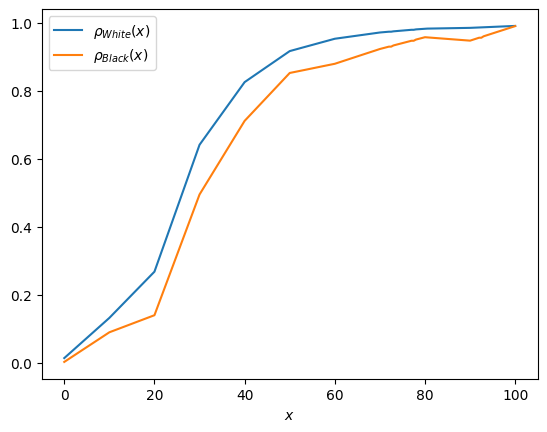

In [4]:
plt.plot(df_risk["Score"], 1-df_risk["Non- Hispanic white"]/100)
plt.plot(df_risk["Score"], 1-df_risk["Black"]/100)
plt.xlabel(r'$x$')
plt.legend([r'$\rho_{White}(x)$' , r'$\rho_{Black}(x)$']);

In [5]:
df_CDF = pd.read_csv("transrisk_cdf_by_race_ssa.csv")

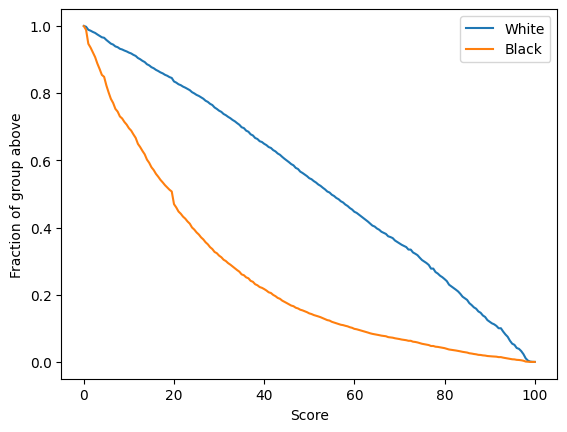

In [6]:
plt.plot(df_CDF["Score"], 1-df_CDF["Non- Hispanic white"]/100)
plt.plot(df_CDF["Score"], 1-df_CDF["Black"]/100)
plt.xlabel('Score')
plt.ylabel('Fraction of group above')
plt.legend(['White' , 'Black']);

In [7]:
pi_A = np.zeros(201)
pi_A[0] = df_CDF[df_CDF["Score"] == 0]["Black"]
for i in range(0,200):
  pi_A[i+1] = float(df_CDF[df_CDF["Score"] == i/2+0.5]["Black"]) -  float(df_CDF[df_CDF["Score"] == i/2]["Black"])

pi_B = np.zeros(201)
pi_B[0] = df_CDF[df_CDF["Score"] == 0]["Non- Hispanic white"]
for i in range(0,200):
  pi_B[i+1] = float(df_CDF[df_CDF["Score"] == i/2+0.5]["Non- Hispanic white"]) -  float(df_CDF[df_CDF["Score"] == i/2]["Non- Hispanic white"])

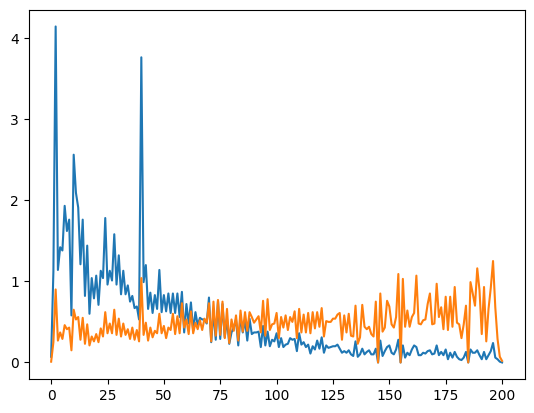

In [9]:
plt.plot(pi_A)
plt.plot(pi_B)
plt.show()

In [8]:
rho_A = 1-df_risk["Black"]/100
rho_B = 1-df_risk["Non- Hispanic white"]/100

In [9]:
def individual_utility(x, rho, u_plus=1, u_minus=-10):
  #### TODO
  u = u_plus*rho[x] + u_minus*(1 - rho[x])
  return u


def all_utility(tau_A, tau_B, pi_A, pi_B, rho_A, rho_B,
                u_plus=1,u_minus=-10, g_A=0.18):
  ### TODO
  g_B = 1 - g_A
  pi_u_A, pi_u_B = 0, 0

  for i in range(201):
    x = df_risk["Score"][i]

    if x >= tau_A:
      pi_u_A += pi_A[i] * individual_utility(i, rho_A, u_plus, u_minus)
    if x >= tau_B:
      pi_u_B += pi_B[i] * individual_utility(i, rho_B, u_plus, u_minus)

  u_all = g_A * pi_u_A + g_B * pi_u_B

  return u_all


def maxUtil(pi_A, pi_B, rho_A, rho_B, u_plus=1, u_minus=-10, g_A=0.18):
  '''
  Returns the thresholds tau_A, tau_B for which the utility of the bank
  is maximized.
  '''
  ### TODO
  tau_A, tau_B = 0, 0
  max_util = 0

  for i in range(201):
    curr_util = 0
    for j in range(201):
      curr_util = all_utility(i/2, j/2, pi_A, pi_B, rho_A, rho_B, u_plus, u_minus, g_A)

      if curr_util > max_util:
        max_util = curr_util
        tau_A = i/2
        tau_B = j/2

  return tau_A, tau_B


def check_demParity(tau_A, tau_B, pi_A, pi_B):
  '''
  Checks whether demogrphic parity is satisfied.
  '''
  ### TODO
  idx_A = np.arange(int(2*tau_A), 201)
  idx_B = np.arange(int(2*tau_B), 201)

  pi_A_accept = pi_A[idx_A]
  pi_B_accept = pi_B[idx_B]

  return pi_A_accept.sum() == pi_B_accept.sum()


def demParity(pi_A, pi_B, rho_A, rho_B, u_plus=1,u_minus=-10,g_A=0.18):
  '''
  Returns the thresholds tau_A, tau_B for which the utility of the bank
  is maximized while demogrphic parity.
  '''
  ### TODO
  tau_A, tau_B = 0, 0
  max_util = 0

  for i in range(201):
    curr_util = 0
    for j in range(201):
      curr_util = all_utility(i/2, j/2, pi_A, pi_B, rho_A, rho_B, u_plus, u_minus, g_A)

      if curr_util > max_util and check_demParity(i/2, j/2, pi_A, pi_B):
        max_util = curr_util
        tau_A = i/2
        tau_B = j/2

  return tau_A, tau_B


def check_eqOpp(tau_A,tau_B,pi_A, pi_B, rho_A, rho_B,   slack = 0.0001):
  '''
  Checks whether equal opportunity is satisfied.
  '''
  ### TODO
  idx_A = np.arange(int(2*tau_A), 201)
  idx_B = np.arange(int(2*tau_B), 201)

  rho_A = rho_A.to_numpy()
  rho_B = rho_B.to_numpy()

  rho_A_accept = rho_A[idx_A]
  rho_B_accept = rho_B[idx_B]

  pi_A_accept = pi_A[idx_A]
  pi_B_accept = pi_B[idx_B]

  p_A = (pi_A_accept * rho_A_accept).sum() / (pi_A * rho_A).sum()
  p_B = (pi_B_accept * rho_B_accept).sum() / (pi_B * rho_B).sum()

  return abs(p_A - p_B) <= slack


def eqOpp(pi_A, pi_B, rho_A, rho_B, u_plus=1,u_minus=-10,g_A=0.18):
  '''
  Returns the thresholds tau_A, tau_B for which the utility of the bank
  is maximized while satisfying equal opportunity.
  '''
  ### TODO
  tau_A, tau_B = 0, 0
  max_util = 0

  for i in range(201):
    curr_util = 0
    for j in range(201):
      curr_util = all_utility(i/2, j/2, pi_A, pi_B, rho_A, rho_B, u_plus, u_minus, g_A)

      if curr_util > max_util and check_eqOpp(i/2, j/2, pi_A, pi_B, rho_A, rho_B):
        max_util = curr_util
        tau_A = i/2
        tau_B = j/2

  return tau_A, tau_B


In [13]:
%%time
tau_A_max, tau_B_max = maxUtil(pi_A, pi_B, rho_A, rho_B, u_plus=1, u_minus=-10)
tau_A_demParity, tau_B_demParity = demParity(pi_A, pi_B, rho_A, rho_B)
tau_A_eqOpp, tau_B_eqOpp = eqOpp(pi_A, pi_B, rho_A, rho_B)

CPU times: user 6min 16s, sys: 578 ms, total: 6min 16s
Wall time: 6min 34s


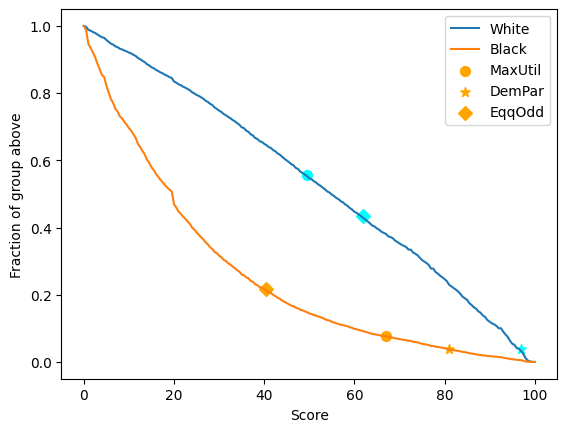

In [14]:
plt.plot(df_CDF["Score"], 1-df_CDF["Non- Hispanic white"]/100)
plt.plot(df_CDF["Score"], 1-df_CDF["Black"]/100)
plt.scatter(tau_A_max,pi_A[np.arange(int(2*tau_A_max),200)].sum()/100,s=50,c='orange',marker="o")
plt.scatter(tau_A_demParity,pi_A[np.arange(int(2*tau_A_demParity),200)].sum()/100,s=50,c='orange',marker="*")
plt.scatter(tau_A_eqOpp,pi_A[np.arange(int(2*tau_A_eqOpp),200)].sum()/100,s=50,c='orange',marker="D")
plt.scatter(tau_B_max,pi_B[np.arange(int(2*tau_B_max),200)].sum()/100,s=50,c='cyan',marker="o")
plt.scatter(tau_B_demParity,pi_B[np.arange(int(2*tau_B_demParity),200)].sum()/100,s=50,c='cyan',marker="*")
plt.scatter(tau_B_eqOpp,pi_B[np.arange(int(2*tau_B_eqOpp),200)].sum()/100,s=50,c='cyan',marker="D")
plt.xlabel('Score')
plt.ylabel('Fraction of group above')
plt.legend(['White' , 'Black', "MaxUtil", "DemPar", "EqqOdd"]);

In [10]:
def DeltaMu(tau, pi, rho, c_plus=75, c_minus=-150):
  '''
  Calulates the average change for a group.
  '''
  ### TODO
  idxs = np.arange(int(2*tau), 200)
  rho = rho.to_numpy()[idxs]
  pi = pi[idxs]

  delta = c_plus * rho + c_minus * (1 - rho)
  delta_mu = (pi * delta).sum()

  return delta_mu


In [16]:
print("Max Util A: {:.2f} B: {:.2f}".format(
    DeltaMu(tau_A_max,pi_A,rho_A),DeltaMu(tau_B_max,pi_B,rho_B)))
print("Dem Par  A: {:.2f} B: {:.2f}".format(
    DeltaMu(tau_A_demParity,pi_A,rho_A),DeltaMu(tau_B_demParity,pi_B,rho_B)))
print("EqOpp    A: {:.2f} B: {:.2f}".format(
    DeltaMu(tau_A_eqOpp,pi_A,rho_A),DeltaMu(tau_B_eqOpp,pi_B,rho_B)))

Max Util A: 489.15 B: 3809.32
Dem Par  A: 256.79 B: 281.40
EqOpp    A: 988.39 B: 3055.18


## 5. Finding a harm causing proportion

In [11]:
### TODO
g_A_harm = 0.0115
tau_A_demParity_harm = demParity(pi_A, pi_B, rho_A, rho_B, u_plus=1, u_minus=-10, g_A=g_A_harm)[0]
##
print("For g_A={:.3f} demParity chooses tau_A={:.1f} and causes DeltaMuA={:.2f}.".format(
    g_A_harm,tau_A_demParity_harm,DeltaMu(tau_A_demParity_harm,pi_A,rho_A)))

For g_A=0.011 demParity chooses tau_A=20.0 and causes DeltaMuA=-811.46.
